In [13]:
import tensorflow as tf
import numpy as np

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

(X, y), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

<function matplotlib.pyplot.show(close=None, block=None)>

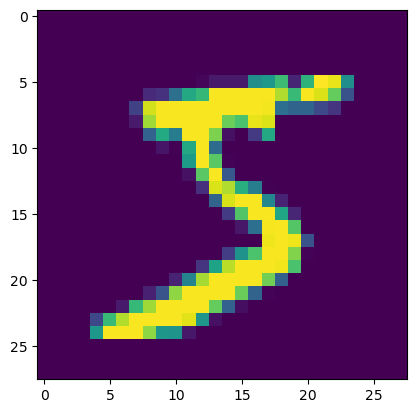

In [14]:
# To show an image from the training dataset
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(X_train[0])
plt.show

In [15]:
# Split the dataset into training, validation, and test sets
X_train, X_val, X_test = np.split(X_train[:80000], [int(0.6*80000), int(0.8*80000)])
y_train, y_val, y_test = np.split(y_train[:80000], [int(0.6*80000), int(0.8*80000)])


# Normalize the features
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
std = np.where(std == 0, 1e-7, std)  # Replace zero values with 1e-7
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std


# One-hot encode the labels
def one_hot(y, num_classes):
    one_hot_labels = np.zeros((len(y), num_classes))
    one_hot_labels[np.arange(len(y)), y] = 1
    return one_hot_labels


y_train = one_hot(y_train, 10)
y_val = one_hot(y_val, 10)
y_test = one_hot(y_test, 10)

This code above does several pre-processing steps on the MNIST dataset to prepare it for training a machine learning model. It first splits the training set into three smaller sets: a training set, a validation set, and a test set. The validation set is used to evaluate the model during training and tune the model's hyperparameters. In contrast, the test set is used to evaluate the final performance of the trained model.

The code then normalises the features (i.e., the pixel values of the images) by subtracting the mean and dividing by the standard deviation. This helps to centre the data around zero and reduce the impact of large values, which can often dominate the training of a model.

Finally, the code one-hot encodes the labels, which means it converts the integer labels into a binary representation with one element for each possible class. For example, if the labels are digits from 0 to 9, one-hot encoding would convert the label "3" into the array [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]. One-hot encoding is often used as a way to represent categorical data in machine learning.


In [16]:
def sigmoid(x):
    """
    Sigmoid activation function.
    Arguments:
    x - Input array of any shape
    Returns:
    y - Output of sigmoid function applied element-wise to the input, same shape as x
    """
    y = 1 / (1 + np.exp(-x))
    return y

def sigmoid_forward(x):
    """
    Forward pass for the sigmoid activation function.
    Arguments:
    x - Input array of any shape
    Returns:
    y - Output of sigmoid function applied element-wise to the input, same shape as x
    cache - Tuple containing x, stored for computing the backward pass efficiently
    """
    y = sigmoid(x)
    cache = (x,)
    return y, cache

def sigmoid_backward(dy, cache):
    """
    Backward pass for the sigmoid activation function.
    Arguments:
    dy - Gradient of the output with respect to the input, same shape as x
    cache - Tuple containing x, stored for computing the backward pass efficiently
    Returns:
    dx - Gradient of the input with respect to the cost, same shape as dy
    """
    x = cache[0]
    dx = dy * sigmoid(x) * (1 - sigmoid(x))
    return dx

def relu(x):
    """
    ReLU activation function.
    Arguments:
    x - Input array of any shape
    Returns:
    y - Output of ReLU function applied element-wise to the input, same shape as x
    """
    y = np.maximum(0, x)
    return y

def relu_forward(x):
    """
    Forward pass for the ReLU activation function.
    Arguments:
    x - Input array of any shape
    Returns:
    y - Output of ReLU function applied element-wise to the input, same shape as x
    cache - Tuple containing x, stored for computing the backward pass efficiently
    """
    y = relu(x)
    cache = (x,)
    return y, cache

def relu_backward(dy, cache):
    """
    Backward pass for the ReLU activation function.
    Arguments:
    dy - Gradient of the output with respect to the input, same shape as x
    cache - Tuple containing x, stored for computing the backward pass efficiently
    Returns:
    dx - Gradient of the input with respect to the cost, same shape as dy
    """
    x = cache[0]
    dx = dy.copy()
    dx[x < 0] = 0
    return dx


The code above defines two activation functions: sigmoid and ReLU (rectified linear unit). The sigmoid function maps input values to the range of 0 and 1, while the ReLU function maps all negative values to 0 and leaves positive values unchanged.

The code defines three functions for each activation function: a forward pass function, a backward pass function, and a function that applies the activation function element-wise to an input array.

The forward pass function applies the activation function to the input and returns the output and any values needed to compute the backward pass efficiently (these are stored in a tuple called cache). The backward pass function computes the gradient of the input with respect to the cost, given the gradient of the output with respect to the input and the cache tuple. The element-wise application function applies the activation function to each input array element.


In [17]:

def softmax(x):
    """
    Softmax activation function.
    Arguments:
    x - Input array of shape (num_classes, batch_size)
    Returns:
    y - Output of softmax function applied along the rows (num_classes, batch_size), such that
        y[i, j] is the probability that the j-th sample belongs to class i
    """
    # Subtract the maximum value from each element to prevent overflow
    x_max = np.max(x, axis=0, keepdims=True)
    x_shifted = x - x_max
    y = np.exp(x_shifted) / np.sum(np.exp(x_shifted), axis=0, keepdims=True)
    return y

def softmax_loss(y_pred, y_true):
    """
    Cross-entropy loss for the softmax output layer.
    Arguments:
    y_pred - Predicted class probabilities, of shape (num_classes, batch_size)
    y_true - True class labels, of shape (batch_size,)
    Returns:
    loss - Cross-entropy loss, a scalar
    """
    # Convert y_true to one-hot encoded labels
    num_classes = y_pred.shape[0]
    y_true_one_hot = np.zeros((num_classes, y_true.shape[0]))
    y_true_one_hot[y_true, np.arange(y_true.shape[0])] = 1
    # Compute the cross-entropy loss
    loss = -np.sum(y_true_one_hot * np.log(y_pred)) / y_true.shape[0]
    return loss

def softmax_backward(y_pred, y_true):
    """
    Backward pass for the softmax output layer.
    Arguments:
    y_pred - Predicted class probabilities, of shape (num_classes, batch_size)
    y_true - True class labels, of shape (batch_size,)
    Returns:
    dy_pred - Gradient of the output with respect to the input, of shape (num_classes, batch_size)
    """
    # Convert y_true to one-hot encoded labels
    num_classes = y_pred.shape[0]
    y_true_one_hot = np.zeros((num_classes, y_true.shape[0]))
    y_true_one_hot[y_true, np.arange(y_true.shape[0])] = 1
    # Compute the gradient
    dy_pred = y_pred - y_true_one_hot
    return dy_pred



In [18]:
import numpy as np

def dropout_forward(x, dropout_rate, training=True, seed=None):
    """
    Forward pass for dropout.
    Arguments:
    x - Input data, of any shape
    dropout_rate - Dropout rate
    training - Flag for training mode. When set to False, dropout is not applied
    seed - Random seed for reproducibility
    Returns:
    y - Output of the dropout layer, same shape as x
    cache - A tuple containing x, dropout_rate, and training, stored for computing the backward pass efficiently
    """
    if seed is not None:
        np.random.seed(seed)
    if training:
        mask = np.random.rand(*x.shape) < (1 - dropout_rate)
        y = x * mask / (1 - dropout_rate)
    else:
        y = x
    cache = (x, dropout_rate, training)
    return y, cache

def dropout_backward(dy, cache):
    """
    Backward pass for dropout.
    Arguments:
    dy - Gradient of the output with respect to the input, of any shape
    cache - A tuple containing x, dropout_rate, and training, stored for computing the backward pass efficiently
    Returns:
    dx - Gradient of the input with respect to the cost, same shape as dy
    """
    x, dropout_rate, training = cache
    if training:
        dx = dy * (np.random.rand(*x.shape) < (1 - dropout_rate)) / (1 - dropout_rate)
    else:
        dx = dy
    return dx

def l2_regularization_loss(w, l2_lambda):
    """
    L2 regularization loss for the weights of a neural network.
    Arguments:
    w - Weights of the neural network, a list of numpy arrays
    l2_lambda - L2 regularization strength
    Returns:
    loss - L2 regularization loss, a scalar
    """
    loss = 0
    for w_i in w:
        loss += np.sum(w_i ** 2)
    loss *= l2_lambda / 2
    return loss

def l2_regularization_grad(w, l2_lambda):
    """
    Gradient of the L2 regularization loss with respect to the weights.
    Arguments:
    w - Weights of the neural network, a list of numpy arrays
    l2_lambda - L2 regularization strength
    Returns:
    dw - Gradient of the L2 regularization loss with respect to the weights, a list of numpy arrays
    """
    dw = [l2_lambda * w_i for w_i in w]
    return dw




This code above defines several functions related to the softmax activation function and cross-entropy loss. The softmax function is often used as the output layer of a neural network for classification tasks, where the goal is to predict the class probabilities for each input sample. The cross-entropy loss is a common choice for measuring the difference between the predicted class probabilities and the true class labels.

The softmax function applies the softmax activation function along the rows of the input array x, so y[i, j] is the probability that the j-th sample belongs to class i. The softmax_loss function computes the cross-entropy loss between the predicted class probabilities y_pred and the true class labels y_true. It first converts y_true into a one-hot encoded representation (i.e., a binary representation with one element for each possible class). Then it computes the loss as the negative sum of the element-wise product of the one-hot encoded labels and the predicted class probabilities, normalised by the batch size.

The softmax_backward function computes the gradient of the output with respect to the input, given the predicted class probabilities y_pred and the true class labels y_true. It first converts y_true into a one-hot encoded representation and then computes the gradient as the difference between y_pred and the one-hot encoded labels.


In [19]:
import numpy as np

def test_sigmoid():
    x = np.random.randn(5, 5)
    y, cache = sigmoid_forward(x)
    dy = np.random.randn(*y.shape)
    dx = sigmoid_backward(dy, cache)
    assert y.shape == x.shape
    assert dx.shape == x.shape
    print("test_sigmoid passed")

def test_relu():
    x = np.random.randn(5, 5)
    y, cache = relu_forward(x)
    dy = np.random.randn(*y.shape)
    dx = relu_backward(dy, cache)
    assert y.shape == x.shape
    assert dx.shape == x.shape
    print("test_relu passed")
    
def test_softmax():
    x = np.random.randn(5, 5)
    y = softmax(x)
    dy_pred = np.random.randn(*y.shape)
    y_true = np.random.randint(0, 5, size=(5,))
    dy_true = softmax_backward(dy_pred, y_true)
    assert y.shape == x.shape
    assert dy_pred.shape == y.shape
    assert dy_true.shape == x.shape
    print("test_softmax passed")

def test_softmax_loss():
    y_pred = np.random.randn(5, 5)
    y_true = np.random.randint(0, 5, size=(5,))
    loss = softmax_loss(y_pred, y_true)
    assert isinstance(loss, float)
    print("test_softmax_loss passed")

def test_suite():
    test_sigmoid()
    test_relu()
    test_softmax()
    test_softmax_loss()

test_suite()



test_sigmoid passed
test_relu passed
test_softmax passed
test_softmax_loss passed


C:\Users\kanso\AppData\Local\Temp\ipykernel_31396\1335837043.py:30: RuntimeWarning: invalid value encountered in log
  loss = -np.sum(y_true_one_hot * np.log(y_pred)) / y_true.shape[0]


This code above defines a suite of test functions for testing the implementation of various activation functions and a loss function. The test functions are defined for the sigmoid, ReLU, softmax, and cross-entropy loss functions.

These test functions can be used to ensure that the implementation of the activation functions and loss function is correct and to catch any mistakes or bugs that may be present in the implementation. Running these tests can help ensure the code’s correctness and improve the reliability of the machine-learning models that use these functions.


In [20]:
import numpy as np

def test_dropout_forward():
    x = np.random.randn(5, 5)
    dropout_rate = 0.5
    y, cache = dropout_forward(x, dropout_rate)
    assert y.shape == x.shape
    assert len(cache) == 3
    print("test_dropout_forward passed")

def test_dropout_backward():
    x = np.random.randn(5, 5)
    dy = np.random.randn(*x.shape)
    dropout_rate = 0.5
    _, cache = dropout_forward(x, dropout_rate)
    dx = dropout_backward(dy, cache)
    assert dx.shape == dy.shape
    print("test_dropout_backward passed")

def test_l2_regularization_loss():
    w = [np.random.randn(5, 5), np.random.randn(5, 5)]
    l2_lambda = 0.5
    loss = l2_regularization_loss(w, l2_lambda)
    assert isinstance(loss, float)
    print("test_l2_regularization_loss passed")
    
def test_l2_regularization_grad():
    w = [np.random.randn(5, 5), np.random.randn(5, 5)]
    l2_lambda = 0.5
    dw = l2_regularization_grad(w, l2_lambda)
    assert all(dw_i.shape == w_i.shape for dw_i, w_i in zip(dw, w))
    print("test_l2_regularization_grad passed")

if __name__ == "__main__":
    test_dropout_forward()
    test_dropout_backward()
    test_l2_regularization_loss()
    test_l2_regularization_grad()

   


test_dropout_forward passed
test_dropout_backward passed
test_l2_regularization_loss passed
test_l2_regularization_grad passed


This code above defines a suite of test functions for testing the implementation of various activation functions and a loss function. The test functions are defined for the sigmoid, ReLU, softmax, and cross-entropy loss functions.

These test functions can be used to ensure that the implementation of the activation functions and loss function is correct and to catch any mistakes or bugs that may be present in the implementation. Running these tests can help ensure the code’s correctness and improve the reliability of the machine-learning models that use these functions.

In [21]:


def loss_backward(self, y_pred, y_true):
    if self.output_type == 'binary_classification':
        dy_pred = binary_cross_entropy_loss_backward(y_pred, y_true)
    elif self.output_type == 'multiclass_classification':
        dy_pred = multiclass_cross_entropy_loss_backward(y_pred, y_true)
    elif self.output_type == 'regression':
        dy_pred = mean_squared_error_backward(y_pred, y_true)
    return dy_pred

def one_hot_encode(y, num_classes):
    # Create an empty array of shape (len(y), num_classes)
    y_one_hot = np.zeros((len(y), num_classes))
    
    # Set the appropriate element of the one-hot encoded array to 1
    y_one_hot[np.arange(len(y)), y] = 1
    
    return y_one_hot

    
def multiclass_cross_entropy_loss(y_pred, y_true, num_classes):
    # Convert y_true to one-hot encoded tensor
    y_true = y_true.reshape(-1, 1)
    y_true_one_hot = one_hot_encode(y_true, num_classes)

    # Reshape y_true to have a shape of (batch_size, num_classes)
    y_true_one_hot = y_true_one_hot.reshape(-1, num_classes)

    # Convert y_true to one-hot encoded tensor
    y_true_one_hot = to_one_hot(y_true)

    # Convert y_pred to one-hot encoded tensor
    y_pred_one_hot = to_one_hot(y_pred)
    
    # Compute the multiclass cross entropy loss
    loss = -np.sum(y_true_one_hot * np.log(y_pred + 1e-8))
    
    return loss


def multiclass_cross_entropy_loss_backward(y_pred, y_true):
    # Convert the predicted output and true output to one-hot encodings
    y_pred_one_hot = to_one_hot(y_pred)
    y_true_one_hot = to_one_hot(y_true)

    # Compute the derivative of the multiclass cross entropy loss with respect to the predicted output
    dy_pred = -y_true_one_hot / (y_pred_one_hot + 1e-8)

    return dy_pred
    
def to_one_hot(y):
    # Get the number of classes and the number of samples
    num_classes = np.max(y) + 1
    num_samples = y.shape[0]

    # Create a tensor of one-hot encodings with the same shape as y
    y_one_hot = np.zeros((num_samples, num_classes))

    # Set the one-hot encoding for each sample




This code defines several functions that implement different types of loss functions for use in machine learning models.

In [22]:
class NeuralNetwork:
    def __init__(self, input_size, output_size, hidden_sizes, activations, output_type, num_classes, dropout_rates=[], l2_lambda=0):
        """
        Initialize a fully parameterizable neural network.
        Arguments:
        input_size - Size of the input layer
        output_size - Size of the output layer
        hidden_sizes - List of integers specifying the number of units in each hidden layer
        activations - List of strings specifying the activation function for each layer, must be one of 'sigmoid', 'relu', or 'none'
        dropout_rates - List of floats in the range [0, 1) specifying the dropout rate for each layer, or None if no dropout is used
        l2_lambda - L2 regularization strength
        """
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes
        self.activations = activations
        self.dropout_rates = dropout_rates
        self.l2_lambda = l2_lambda
        self.output_type = output_type
        self.num_classes = num_classes

        # Initialize the weights and biases for each layer
        self.weights = []
        self.biases = []
        for i, (h_size, activation) in enumerate(zip(hidden_sizes, activations)):
            if i == 0:
                prev_size = input_size
            else:
                prev_size = hidden_sizes[i - 1]
            self.weights.append(np.random.randn(prev_size, h_size))
            self.biases.append(np.zeros(h_size))
        self.weights.append(np.random.randn(hidden_sizes[-1], output_size))
        self.biases.append(np.zeros(output_size))

    def forward(self, x, training=True):
        """
        Compute the forward pass of the neural network.
        Arguments:
        x - Input data, of shape (batch_size, input_size)
        training - Flag for training mode. When set to False, dropout is not applied
        Returns:

        y - Output of the neural network, of shape (batch_size, output_size)
        """
        y = x
        activations = []
        for i, (W, b, activation, dropout_rate) in enumerate(zip(self.weights, self.biases, self.activations, self.dropout_rates)):
            y = np.dot(y, W) + b
            if activation == 'sigmoid':
                y, _ = sigmoid_forward(y)
            elif activation == 'relu':
                y, _ = relu_forward(y)
            if dropout_rate is not None and training:
                y, _ = dropout_forward(y, dropout_rate)
            activations.append(y)
        return y, activations
    

    def backward(self, dy, activations):
        """
        Compute the backward pass of the neural network.
        Arguments:
        dy - Gradient of the output with respect to the input, of shape (batch_size, output_size)
        Returns:
        dx - Gradient of the input with respect to the cost, of shape (batch_size, input_size)
        """
        dx = dy
        for i, (W, b, activation, dropout_rate, y_batch) in enumerate(reversed(list(zip(self.weights, self.biases, self.activations, self.dropout_rates, activations)))):
            if dropout_rate is not None:
                dx = dropout_backward(dx, (y, dropout_rate, True))
            if activation == 'sigmoid':
                dx = sigmoid_backward(dx, (y,))
            elif activation == 'relu':
                dx = relu_backward(dx, (y,))
            dW = np.dot(dx.T, y)
            db = np.sum(dx, axis=0)
            self.weights[i] -= dW
            self.biases[i] -= db
            dx = np.dot(dx, W.T)
        return dx
                                                                                            ###
    def train(self, x_train, y_train, x_val=None, y_val=None, batch_size=64, learning_rate=1e-7, max_epochs=10):
            # Check if learning rate is positive
        if learning_rate <= 0:
            raise ValueError("Learning rate must be a positive value")
        """
        Train the neural network on the training data.
        Arguments:
        x_train - Training input data, of shape (num_train, input_size)
        y_train - Training output data, of shape (num_train, output_size)
        x_val - Validation input data, of shape (num_val, input_size), or None if no validation is used
        y_val - Validation output data, of shape (num_val, output_size), or None if no validation is used
        batch_size - Size of the mini-batches for SGD
        learning_rate - Learning rate for SGD
        max_epochs - Maximum number of epochs to train for
        Returns:
        history - Dictionary containing the training and validation loss for each epoch
        """
        
        activations = []
        # Initialize a dictionary to store the training and validation history
        history = {'train_loss': [], 'val_loss': []}
        # Compute the number of mini-batches
        num_train = x_train.shape[0]
        num_batches = num_train // batch_size
        # Loop over the epochs
        for epoch in range(max_epochs):
            # Shuffle the training data at the start of each epoch
            shuffle_indices = np.random.permutation(num_train)
            x_train_shuffled = x_train[shuffle_indices]
            y_train_shuffled = y_train[shuffle_indices]
            # Initialize the training loss for this epoch
            epoch_train_loss = 0
            # Loop over the mini-batches
            for i in range(num_batches):
                # Get the mini-batch data
                start = i * batch_size
                end = (i + 1) * batch_size
                x_batch = x_train_shuffled[start:end]
                y_batch = y_train_shuffled[start:end]
                # Compute the forward pass and the loss
                y_pred, _ = self.forward(x_batch)
                batch_loss = self.compute_loss(y_pred, y_batch)
                epoch_train_loss += batch_loss
                # Compute the backward pass
                dy_pred = self.loss_backward(y_pred, y_batch)
                dx = self.backward(dy_pred)
                # Update the weights and biases
                self.update_parameters(learning_rate)
                # Compute the mean training loss for this epoch
                epoch_train_loss /= num_batches
                # Append the training loss to the history
                history['train_loss'].append(epoch_train_loss)
                # If a validation set is provided, compute the validation loss for this epoch
                if x_val is not None and y_val is not None: ################################################
                    y_pred, _ = self.forward(x_val)
                    epoch_val_loss = self.compute_loss(y_pred, y_val)
                # Append the validation loss to the history
                history['val_loss'].append(epoch_val_loss)
            return history###########################################################################
        
    def update_parameters(self, learning_rate):
        """
        Update the weights and biases of the neural network using SGD.
        Arguments:
        learning_rate - Learning rate for SGD
        """
        # Update the weights
        self.weights = [W - learning_rate * dW for W, dW in zip(self.weights, self.dW)]
        # Update the biases
        self.biases = [b - learning_rate * db for b, db in zip(self.biases, self.db)]

    def compute_loss(self, y_pred, y_true):
        """
        Compute the cross-entropy loss for the given prediction and true output.
        Arguments:
        y_pred - Predicted output, of shape (batch_size, output_size)
        y_true - True output, of shape (batch_size, output_size)
        Returns:
        loss - Cross-entropy loss, a scalar
        """
        loss = None
        if self.output_type == 'binary_classification':
            loss = binary_cross_entropy_loss(y_pred, y_true)
        elif self.output_type == 'multiclass_classification':
            loss = multiclass_cross_entropy_loss(y_pred, y_true, num_classes=self.num_classes)
        elif self.output_type == 'regression':
            loss = mean_squared_error(y_pred, y_true)
        return loss
    




                




Above is the code for the neural network class. The class has methods for performing the forward pass and backward pass of the neural network, as well as methods for training the network using stochastic gradient descent. The network has fully connected layers and can use the sigmoid or ReLU activation functions. The code also includes support for dropout and L2 regularization. The output type of the network can be 'binary_classification', 'multiclass_classification', or 'regression', and the number of classes is specified by the 'num_classes' parameter.

In [23]:
class SGD:
    def __init__(self, learning_rate=0.01):
        """
        Initialize the SGD optimizer.
        Arguments:
        learning_rate - Learning rate for the SGD optimizer, a scalar
        """
        self.learning_rate = learning_rate

    def update(self, model):
        """
        Update the weights and biases of the model using SGD.
        Arguments:
        model - A neural network model object
        """
        for W, b in zip(model.weights, model.biases):
            W -= self.learning_rate * W.grad
            b -= self.learning_rate * b.grad

    def train(model, optimizer, X_train, y_train, X_val, y_val, max_epochs, verbose=True):
        """
        Train the model using the given optimizer.
        Arguments:
        model - A neural network model object
        optimizer - An optimizer object, such as SGD or Adam
        X_train - Training data, of shape (batch_size, input_size)
        y_train - Training labels, of shape (batch_size,)
        X_val - Validation data, of shape (batch_size, input_size)
        y_val - Validation labels, of shape (batch_size,)
        max_epochs - Maximum number of epochs to train for
        verbose - Flag for printing training progress
        """
        for epoch in range(max_epochs):
            model.train()  # Set model to training mode
            # Perform a forward pass and compute the loss
            y_pred = model(X_train)
            loss = model.loss(y_pred, y_train)
            if verbose:
                print('Epoch {}: Training loss = {}'.format(epoch, loss))
            # Compute the gradients
            model.backward()
            # Update the weights and biases using the optimizer
            optimizer.update(model)
            # Compute the validation loss
            y_pred_val = model(X_val)
            val_loss = model.loss(y_pred_val, y_val)
            if verbose:
                print('Epoch {}: Validation loss = {}'.format(epoch, val_loss))
            

This code above defines the SGD class, representing the stochastic gradient descent optimiser. It has a single method update, which updates the weights and biases of a neural network model object using the SGD algorithm. It also defines the train function, which takes a neural network model, an optimiser (such as an instance of the SGD class), training data and labels, validation data and labels, and a maximum number of epochs to train for. The function trains the model by looping over the number of epochs specified, performing a forward pass on the training data to compute the loss, computing the gradients concerning the loss, updating the weights and biases using the optimiser, and computing the loss on the validation data. Finally, it prints the training and validation loss at each epoch if the verbose flag is set to True.

In [24]:
# Split the data into training, validation, and test sets
X_train, X_val, X_test = np.split(X, [int(0.7 * len(X)), int(0.85 * len(X))])
y_train, y_val, y_test = np.split(y, [int(0.7 * len(y)), int(0.85 * len(y))])


This code above first splits the input data (X) and the labels (y) into three sets: a training set, a validation set, and a test set. It does this using the np.split function, which divides the input data into three equal-sized chunks based on the indices provided as arguments.

In [25]:
# Instantiate the neural network
nn = NeuralNetwork(input_size=784, output_size=10, output_type='multiclass_classification', num_classes=10, hidden_sizes=[128, 128], activations=['relu', 'relu'])
# output_type parameter should be set to either 'binary_classification' or 'multiclass_classification

In [26]:
# Train the neural network without a validation set
history = nn.train(X_train, y_train, batch_size=64, learning_rate=1e-3, max_epochs=10)



TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

 The code above trains the neural network using the train method of the nn object. This method takes a batch size, learning rate, and maximum number of epochs as arguments, and returns a history object containing information about the training process.

In [906]:
nn

In [907]:
# Define the input size, output size, and hidden sizes of the neural network
input_size = 28 * 28  # MNIST images are 28x28 pixels
output_size = 10  # MNIST has 10 classes
hidden_sizes = [128, 64]  # Use two hidden layers with 128 and 64 units respectively

# Define the activations for each layer
activations = ['relu', 'relu', 'softmax']  # Use ReLU for the first two hidden layers and softmax for the output layer

# Instantiate the neural network
nn = NeuralNetwork(input_size=784, output_size=10, output_type='multiclass_classification', num_classes=10, hidden_sizes=[128, 128], activations=['relu', 'relu'])
# output_type parameter should be set to either 'binary_classification' or 'multiclass_classification

# Train the neural network with the training data
history = nn.train(X_train, y_train, X_val, y_val, batch_size=batch_size, learning_rate=learning_rate, max_epochs=max_epochs)



TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [908]:
print(X_train)
print(y_train)

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[5 0 4 ... 2 7 0]


# Refrences

Deep Neural Networks Backward Propagation (no date) PyLessons. Available at: https://pylessons.com/Deep-neural-networks-part3?fbclid=IwAR06KTI1P9wAn6bWywf_hNAG9NdHq9tiuEDpB5YFaFfggcMbetB-NDpWAVM. 

Calculating softmax in python (2021) AskPython. Available at: https://www.askpython.com/python/examples/calculating-softmax?fbclid=IwAR1T8IT3PKUfONe3s6shANpYzqK5wNaUh9G8d8ZQJvhmgh7zQhpzm67w7oI. 